In [ ]:
#This code was give in the site give in the project description
#This function uses the pickle library to convert the
#serialized binary data to a dictionary format
#(key -> object_name, values -> images in tensor form)

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



In [ ]:
import numpy as np

# Load training data
train_data = unpickle("train")
print(train_data.keys())  # Checking what keys exist

train_images = np.array(train_data[b"data"])  # Shape: (50000, 3072)
train_labels = np.array(train_data[b"fine_labels"])  # Shape: (50000,)

# print(f"data -> {train_images.shape}")
# print(f"labels -> {train_labels.shape}")

#Load test data
test_data = unpickle("test")
test_images = np.array(test_data[b"data"])  # Shape: (10000, 3072)
test_labels = np.array(test_data[b"fine_labels"])  # Shape: (10000,)

# Reshape images to (N, 32, 32, 3)
train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print("Training set shape:", train_images.shape)  # (50000, 32, 32, 3)
print("Test set shape:", test_images.shape)  # (10000, 32, 32, 3)

#as per the site the meta file in the folder contains class names so loading and checking

meta_data = unpickle("meta")
#print(meta_data.keys())
class_names = [x.decode("utf-8") for x in meta_data[b"fine_label_names"]]
print("Class labels:", class_names)
print(len(class_names))



dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Class labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'stre

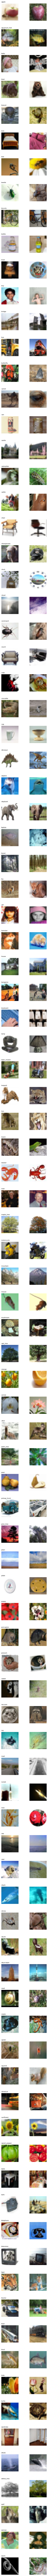

In [ ]:
#visulizing and cross checking the data for further applications
import numpy as np
import matplotlib.pyplot as plt

# Assuming `train_images` (shape: (N, 32, 32, 3)) and `train_labels` (shape: (N,))
# Assuming `class_labels` contains the names of 100 classes.

fig, axes = plt.subplots(100, 2, figsize=(5, 250))  # 100 rows (classes), 2 columns (images per class)
plt.subplots_adjust(hspace=0.5)

for i in range(100):  # Loop through 100 classes
    class_indices = np.where(train_labels == i)[0]  # Find indices of this class
    selected_images = class_indices[:2]  # Pick first 2 images of this class

    for j, img_idx in enumerate(selected_images):
        ax = axes[i, j]
        ax.imshow(train_images[img_idx])
        ax.axis("off")
        if j == 0:  # Add label only to the first image in each row
            ax.set_title(class_names[i], fontsize=8, loc='left')

plt.show()


In [ ]:
#working on 32 * 32 * 3 data could make computations large and time complexity in case of some algos like knn and lr
#increases drastically so applying dimensionality reduction by feature extraction using PCA

#scratch code of applying PCA on the above data
def pca(images,variance_ratio = 0.9):
  #PCA works on 2-D data so flattening the tensors i created
  N, H, W, C = images.shape  # (N, 32, 32, 3)
  flattened_images = images.reshape(N, -1)  # Shape: (N, 3072)


  #Step - 1 - Mean centre and stardize the data z= x - u/sigma
  mean = np.mean(flattened_images, axis=0)  # Mean of each feature
  std = np.std(flattened_images, axis=0) + 1e-10  # Avoid division by zero
  standardized_images = (flattened_images - mean) / std

  #Step -2 -> Computing the co-variance matrix
  covariance_matrix = np.cov(standardized_images, rowvar=False)  # Shape: (3072, 3072)

  #Step - 3 -> calculating the eigen valiues and vector directly by using the numpy lib
  eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)  # eigh() for symmetric matrices

  #eigen values(it shows the weight of the eigen vector in explaining the output),
  #hence arranging the eigen vals and their corresponding vectors in decending order
  sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort eigenvalues in descending order
  eigenvalues = eigenvalues[sorted_indices]
  eigenvectors = eigenvectors[:, sorted_indices]  # Eigenvectors sorted accordingly

# Step- 4 -> Finding the optimal no. of features for explaing the variance_ratio fraction of data
  total_variance = np.sum(eigenvalues)
  explained_variance = np.cumsum(eigenvalues) / total_variance  # Cumulative variance ratio

  # Find minimum number of components where explained_variance >= variance_ratio
  optimal_components = np.argmax(explained_variance >= variance_ratio) + 1  # 1-based index
  print("Initially the data has 32*32*3 features ,3072")
  print(f"Optimal number of components for {variance_ratio * 100}% variance: {optimal_components}")

  # Step 7: Project Data onto Principal Components
  top_eigenvectors = eigenvectors[:, :optimal_components]  # Selecting the top components
  reduced_data = np.dot(standardized_images, top_eigenvectors)  # Shape: (N, optimal_components)
  return reduced_data, optimal_components

variance_ratio = 0.9  # 90% variance explained
train_pca, optimal_components = pca(train_images, variance_ratio)
test_pca, _ = pca(test_images, variance_ratio)

Initially the data has 32*32*3 features ,3072
Optimal number of components for 90.0% variance: 90
Initially the data has 32*32*3 features ,3072
Optimal number of components for 90.0% variance: 90
